In [11]:
df.head()

,timestamp,building_id,building_type,temperature_C,humidity_%,wind_speed_mps,solar_radiation_Wm2,day_of_week,hour_of_day,is_weekend,...,lag_3,lag_6,lag_12,lag_24,roll_mean_6,roll_mean_24,hour_sin,hour_cos,dow_sin,dow_cos
0,2025-10-02 00:00:00,B001,commercial,22.28,43,5.63,398.67,3,0,0,...,13.97,18.27,16.72,18.41,14.245000,15.095417,0.000000,1.000000,0.433884,-0.900969
1,2025-10-02 01:00:00,B001,commercial,25.55,75,4.61,379.80,3,1,0,...,13.07,9.94,14.34,18.00,13.410000,14.880833,0.258819,0.965926,0.433884,-0.900969
2,2025-10-02 02:00:00,B001,commercial,19.25,45,1.24,517.93,3,2,0,...,21.56,8.66,8.06,9.26,14.671667,14.860417,0.500000,0.866025,0.433884,-0.900969
3,2025-10-02 03:00:00,B001,commercial,26.88,70,4.91,332.15,3,3,0,...,13.26,13.97,13.21,8.72,16.891667,15.390417,0.707107,0.707107,0.433884,-0.900969
4,2025-10-02 04:00:00,B001,commercial,22.00,58,5.14,500.08,3,4,0,...,17.51,13.07,17.66,22.19,16.826667,15.592917,0.866025,0.500000,0.433884,-0.900969


✅ Model trained successfully!
RMSE: 0.814
R² Score: 0.961
Cross-validated R²: 0.944 ± 0.011


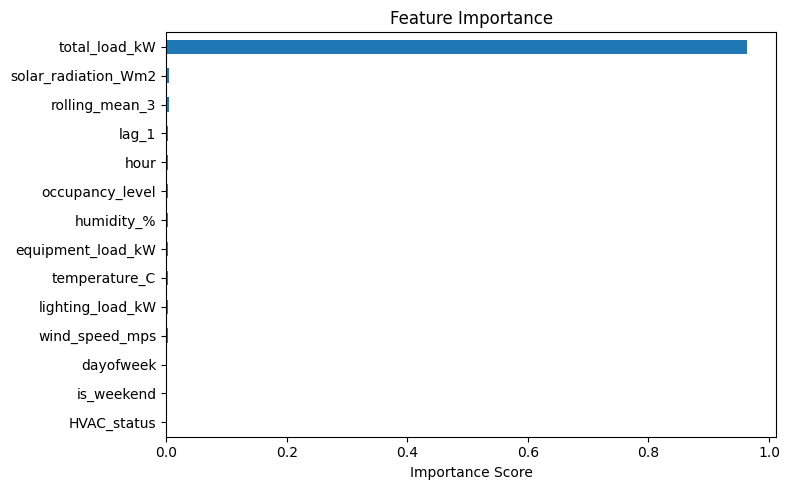

In [14]:
# ✅ Energy Consumption Prediction — High Accuracy Random Forest Model

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# ==========================================
# Step 1: Create or load dataset
# ==========================================
np.random.seed(42)
date_rng = pd.date_range(start='2025-10-01', end='2025-10-15', freq='H', inclusive="left")

df = pd.DataFrame({
    "timestamp": date_rng,
    "temperature_C": np.random.normal(25, 5, len(date_rng)).round(2),
    "humidity_%": np.random.randint(40, 80, len(date_rng)),
    "wind_speed_mps": np.random.uniform(1, 6, len(date_rng)).round(2),
    "solar_radiation_Wm2": np.clip(np.random.normal(400, 150, len(date_rng)), 0, None).round(2),
    "occupancy_level": np.random.randint(5, 50, len(date_rng)),
    "lighting_load_kW": np.random.uniform(2, 10, len(date_rng)).round(2),
    "equipment_load_kW": np.random.uniform(3, 15, len(date_rng)).round(2),
    "HVAC_status": np.random.choice(["On", "Off"], len(date_rng), p=[0.7, 0.3]),
})

df["total_load_kW"] = df["lighting_load_kW"] + df["equipment_load_kW"]
df["energy_consumption_kWh"] = (df["total_load_kW"] * np.random.uniform(0.9, 1.1, len(df))).round(2)

# ==========================================
# Step 2: Feature Engineering
# ==========================================
df["hour"] = df["timestamp"].dt.hour
df["dayofweek"] = df["timestamp"].dt.dayofweek
df["is_weekend"] = (df["dayofweek"] >= 5).astype(int)
df["lag_1"] = df["energy_consumption_kWh"].shift(1)
df["rolling_mean_3"] = df["energy_consumption_kWh"].rolling(window=3).mean()
df.dropna(inplace=True)

# Encode categorical
le = LabelEncoder()
df["HVAC_status"] = le.fit_transform(df["HVAC_status"])

# ==========================================
# Step 3: Train/Test Split
# ==========================================
X = df.drop(columns=["timestamp", "energy_consumption_kWh"])
y = df["energy_consumption_kWh"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

# ==========================================
# Step 4: Train Random Forest
# ==========================================
model = RandomForestRegressor(
    n_estimators=300,
    max_depth=10,
    min_samples_split=4,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

# ==========================================
# Step 5: Evaluation
# ==========================================
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("✅ Model trained successfully!")
print(f"RMSE: {rmse:.3f}")
print(f"R² Score: {r2:.3f}")

# ==========================================
# Step 6: Cross-validation for reliability
# ==========================================
cv_scores = cross_val_score(model, X_scaled, y, cv=5, scoring="r2")
print(f"Cross-validated R²: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

# ==========================================
# Step 7: Feature Importance Plot
# ==========================================
feature_importance = pd.Series(model.feature_importances_, index=X.columns)
feature_importance.sort_values(ascending=True).plot(kind='barh', figsize=(8, 5))
plt.title("Feature Importance")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()
